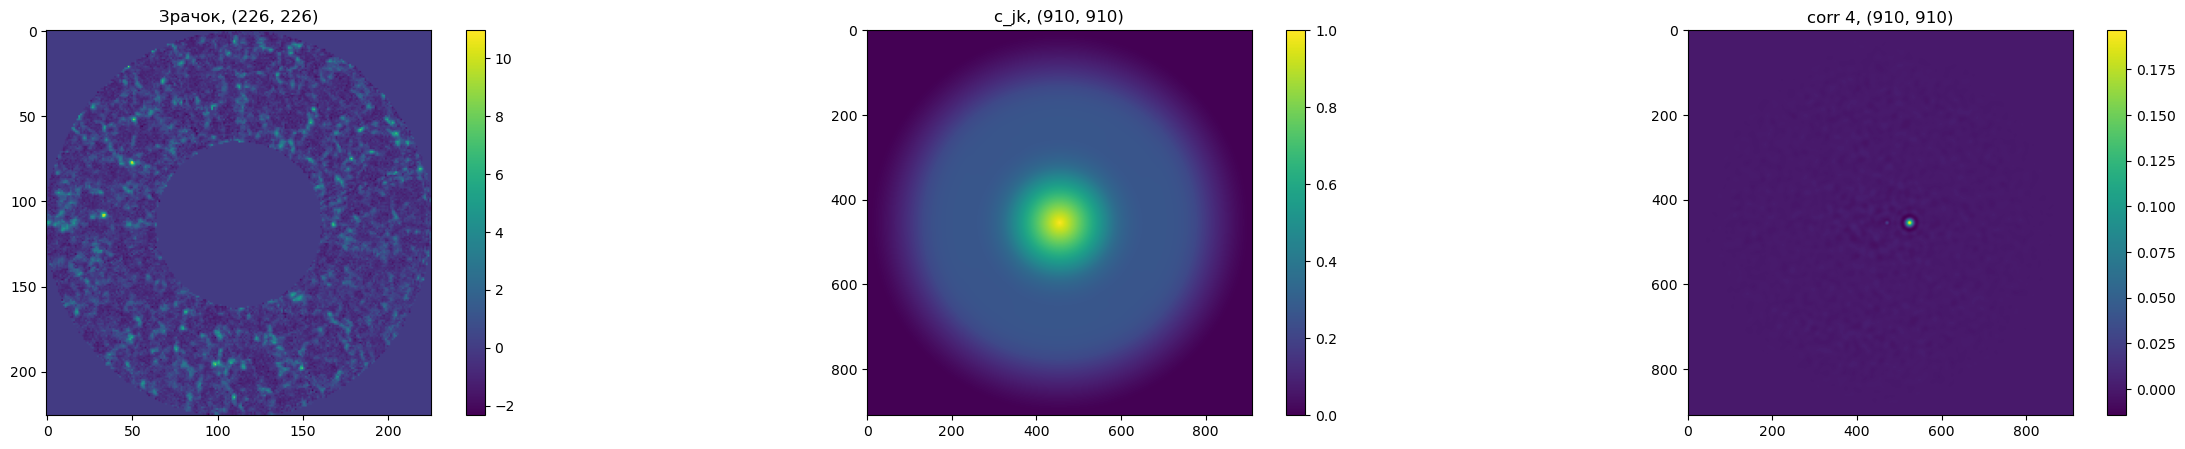

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median
from astropy.io import fits

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    
    Cn2=Cn2*1e-14
    z=z*1000

    # мб дать как то обозначить приоритетность выбора? или че нибудь такое. или шаг типа сделать равнозначный как по
#     высоте, так и по мощности
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
# z0 = 'm2' #  '0' or m2'
data_dir = 'D:/astro/domecam'
# file = '20210130j'
file='defocus2000m_5_130_corr_4_blur'
gammas_type = 'blur'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

if gammas_type == 'orig':
    print('lol')

if gammas_type == 'blur':
#     data = np.loadtxt(f'{data_dir}/{file}_{z0}km_corr_{latency}_blur.gz')
#     gammas = np.load(f'{data_dir}/gammas_blur.npy')
    data = np.loadtxt(f'{data_dir}/{file}.gz')
    gammas = np.load(f'{data_dir}/gammas_blur2.npy')


pupil = np.loadtxt(f'{data_dir}/frame.gz')
cjk = np.loadtxt(f'{data_dir}/cjk2.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 5
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    all_errors = []
    reason = 'empty'
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            all_errors = np.array(all_errors)
            all_errors = all_errors[:-4, :]
            reason = 'Stucked!'
            print('Stucked!')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            print('\nDome turbulence')
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 2))) * 10
            myParams = [0, 0, p0_Cn2, 2]
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window//2)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 15))) * 10
            myParams = [Vx, Vy, p0_Cn2, (15+5*np.sin(np.random.uniform(-np.pi, np.pi)))]  
            psf, params, errors = multi_speckle_fit(myParams, ydata=res, window=window)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        all_errors.append(errors)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
#             fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
#             res2 -= fit
#             cl2 += fit
            
#             plt.figure()
#             plt.imshow(res2)
#             plt.show()
            
#             plt.figure()
#             plt.imshow(cl2)
#             plt.show()
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            reason = 'Thresh reached!'
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    
    if reason == 'empty':
        reason = 'Max number of iteration reached!'
    conf = [reason, tmp+1, time.perf_counter()-st]
    return comps, res, cl, np.array(all_params), np.array(all_errors), conf


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata, window=None):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
#             arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z).ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
#         bounds = [[-np.inf, -np.inf, params[2]-0.01, 0], [np.inf, np.inf, params[2]+0.01, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
        fit += gamma_poly_se(X, Y, *popt)        

        return fit, popt[0], popt[1], popt[2], popt[3], np.sqrt(np.diag(pcov))
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z, errors = speckle_fit(params, ydata, window=window)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z], errors

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

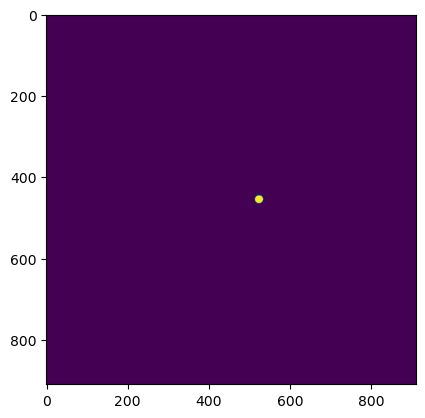

In [61]:
gain=1
niter=50
window=5
thresh_type = 'multiotsu'

if thresh_type == 'otsu':
    thresh = threshold_otsu(data)
if thresh_type == 'multiotsu':
    thresh = threshold_multiotsu(data)[0]
plt.imshow(data>thresh)

Speckle fitting: 18.805309734513273 0.0 3.880421329253589e-13 17726.551686838233


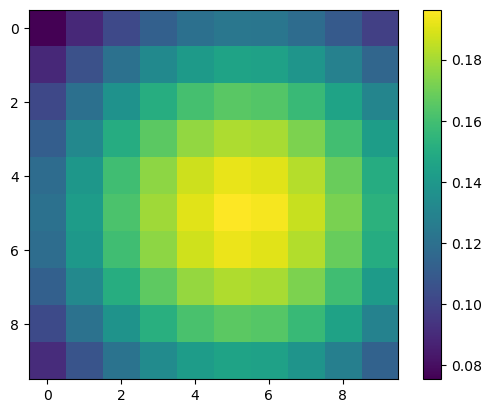

Fitted parametrs: 18.94 -0.00 6.009194709020435e-13 9180.644372143424
time: 2.5235468999999284
test Cn2: 38.80421329253589
-initial value: 0.19636596739292145
-residual value: -0.00043164365121731163
 
Speckle fitting: 4.148230088495575 0.0 3.8587869643482096e-14 11970.107276082072


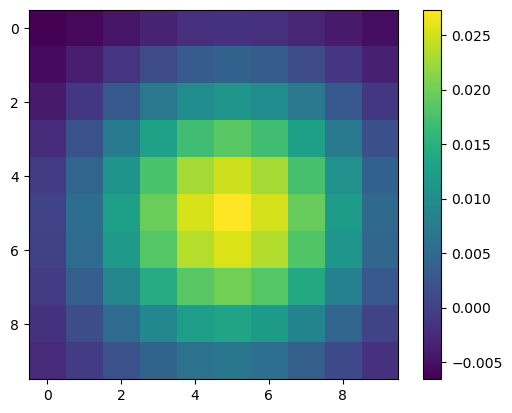

Fitted parametrs: 4.15 -0.06 3.6387508910863713e-13 1413.0181997431919
time: 3.837427999999818
test Cn2: 3.8587869643482096
-initial value: 0.027320511928393135
-residual value: -0.0009890320579483206
 
Total iterations: 2
time: 6.47096799999963


Text(0.5, 1.0, 'max: 0.0087, min: -0.0058')

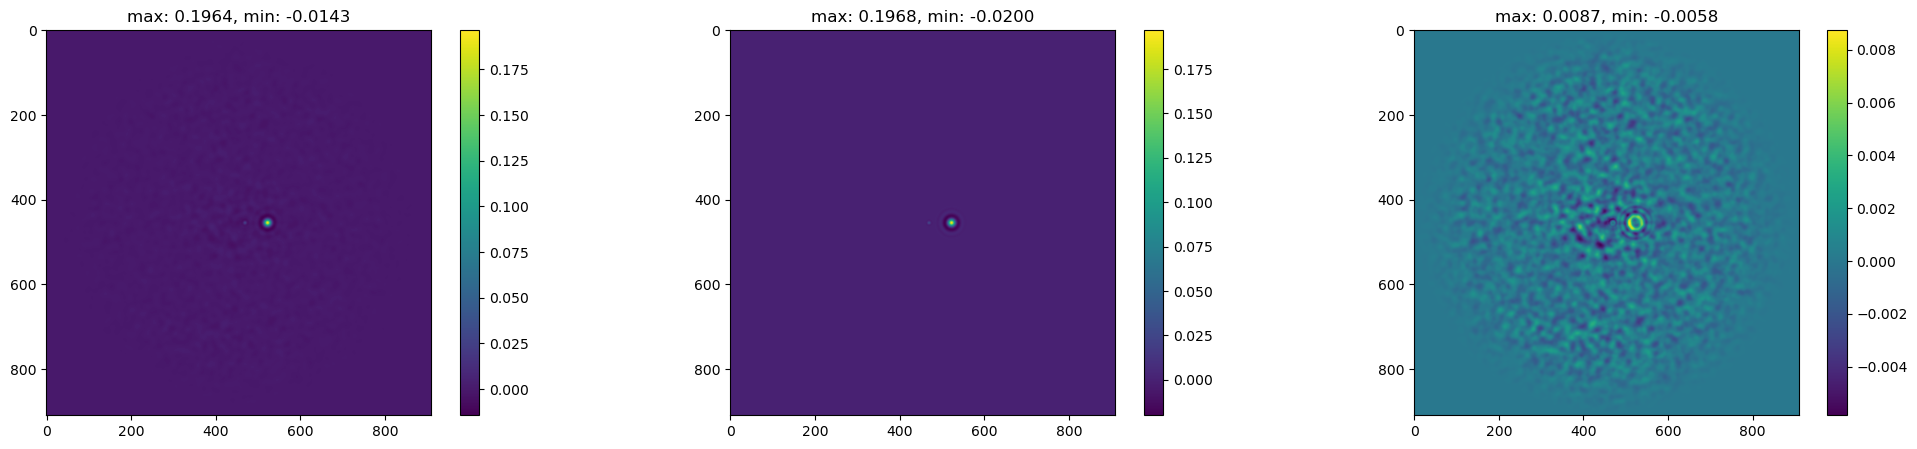

In [69]:
comps, residual, clean, params, errors, conf = CLEAN(data, gain=gain, thresh=thresh-0.1, niter=2, window=window)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

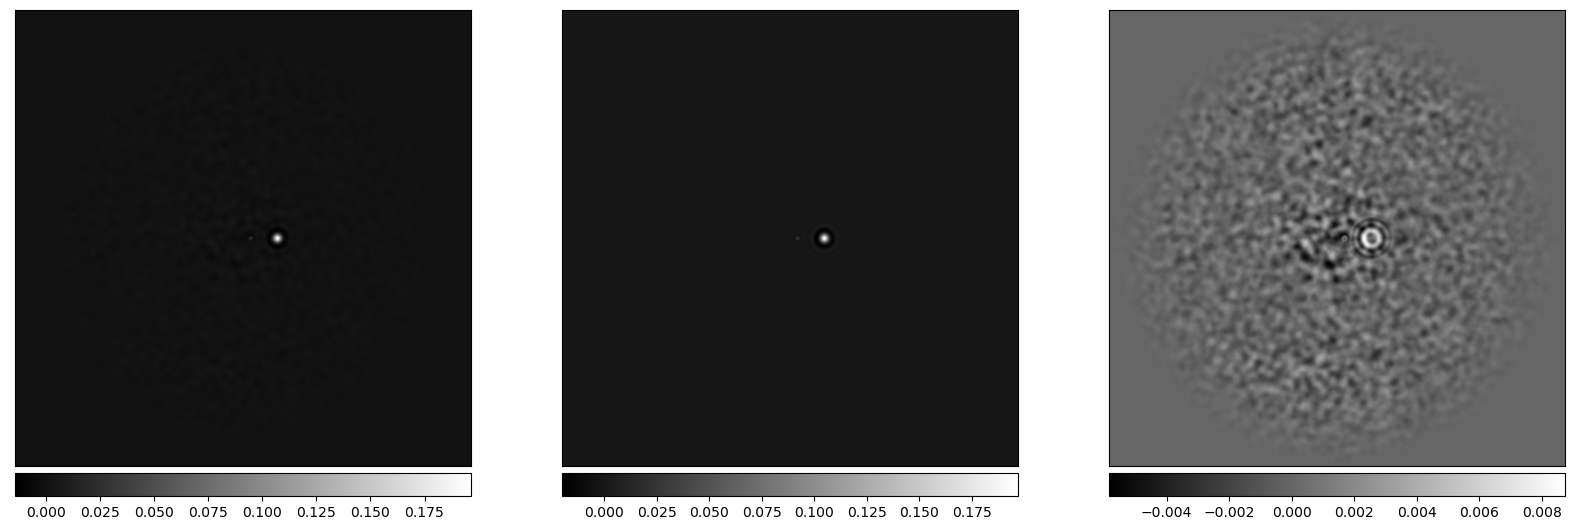

In [72]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10)) 
fig.colorbar(ax.imshow(data, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax) 
fig.colorbar(ax2.imshow(clean, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax2) 
fig.colorbar(ax3.imshow(residual, cmap='gray'), orientation="horizontal", pad=0.01, ax=ax3) 

ax.set_xticks([])
ax.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

# fig.savefig(f'D:/astro/fitting_{file}_{z0}_{latency}.png', bbox_inches='tight')
fig.savefig(f'D:/astro/fitting_test.png', bbox_inches='tight')

          Vx        Vy        Cn2         z
1   4.145547 -0.057467  36.387509  1.413018
0  18.935283 -0.003193  60.091947  9.180644
     err_Vx    err_Vy   err_Cn2     err_z
0  0.001338  0.001280  0.169832  0.023919
1  0.008115  0.008113  1.289507  0.033348
Cn2: 9.647945600106805e-13
1.2306614197545787


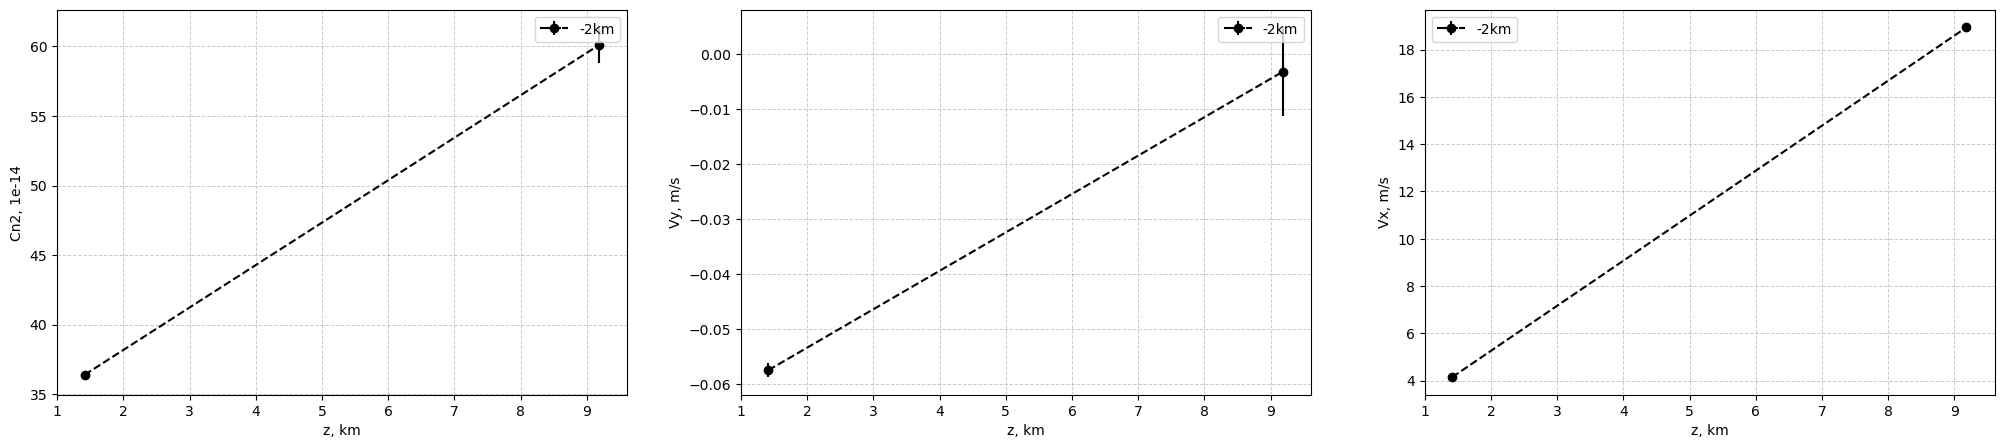

In [73]:
import pandas as pd


df = pd.DataFrame(params, columns = ['Vx','Vy','Cn2', 'z'])
df_err = pd.DataFrame(errors, columns = ['err_Vx','err_Vy','err_Cn2', 'err_z'])

# df = pd.DataFrame(params2, columns = ['Vx','Vy','Cn2', 'z'])
# df_err = pd.DataFrame(errors2, columns = ['err_Vx','err_Vy','err_Cn2', 'err_z'])

# tmp_z = 0
# if z0[0] == 'm':
#     tmp_z = 2
# tmp_z
df = df.sort_values(by=['z'])
# df['z'] = df['z'] - tmp_z
print(df)
print(df_err)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

ax.errorbar(df['z'], df['Cn2'], yerr=df_err['err_Cn2'], xerr=df_err['err_z'], fmt='o--', color='black', label='-2km')
ax2.errorbar(df['z'], df['Vy'], yerr=df_err['err_Vy'], xerr=df_err['err_z'], fmt='o--', color='black', label='-2km')
ax3.errorbar(df['z'], df['Vx'], yerr=df_err['err_Vx'], xerr=df_err['err_z'], fmt='o--', color='black', label='-2km')

# ax.errorbar(df2['z'], df2['Cn2'], yerr=df_err2['err_Cn2'], xerr=df_err2['err_z'], fmt='o--', color='red', label='0km')
# ax2.errorbar(df2['z'], df2['Vy'], yerr=df_err2['err_Vy'], xerr=df_err2['err_z'], fmt='o--', color='red', label='0km')
# ax3.errorbar(df2['z'], df2['Vx'], yerr=df_err2['err_Vx'], xerr=df_err2['err_z'], fmt='o--', color='red', label='0km')

ax.legend()
ax2.legend()
ax3.legend()

ax.set_ylabel('Cn2, 1e-14')
ax.set_xlabel('z, km')
ax2.set_ylabel('Vy, m/s')
ax2.set_xlabel('z, km')
ax3.set_ylabel('Vx, m/s')
ax3.set_xlabel('z, km')

ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

sum_cn2 = np.sum(df['Cn2'])*1e-14
print('Cn2:', sum_cn2)
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0
print(seeing)

# fig.savefig(f'D:/astro/profile_{file}_{z0}_{latency}.png', bbox_inches='tight')
fig.savefig(f'D:/astro/profile_test.png', bbox_inches='tight')

In [12]:
with open(f'D:/astro/config_{file}_{z0}_{latency}.txt', 'w') as f:
    print(f'file: {file}, {z0}km', file=f)
    print('\n-------- General settings -------', file=f)
    print(f'MODE: {gammas_type}', file=f)
    print(f'latency: {latency}', file=f)
    print(f'lambda: {lambda_}', file=f)
    print('\n-------- CLEAN settings -------', file=f)
    print(f'gain: {gain}', file=f)
    print(f'thresh: {thresh_type}', file=f)
    print(f'niter: {niter}', file=f)
    print(f'window: {window}', file=f)
    print('\n-------- CLEAN output -------', file=f)
    print(f'message: {conf[0]}', file=f)
    print(f'num. of iters: {conf[1]}', file=f)
    print(f'time: {conf[2]}', file=f)
    print('\n-------- Results -------', file=f)
    print(f'total cn2: {sum_cn2}', file=f)
    print(f'seeing, 500 nm: {seeing:.2f}', file=f)
    
with open(f'D:/astro/config_{file}_{z0}_{latency}.txt', 'r') as f:
    info = f.read().rstrip('\n')

plt.figure()
plt.imshow(data>thresh, cmap='gray')
plt.text(data.shape[1]+30, data.shape[0]-25, f'config\n\n{info}', fontsize = 10)
plt.xticks([])
plt.yticks([])
plt.title('thresh', fontsize = 10)

# plt.savefig(f'D:/astro/thresh_{file}_{z0}_{latency}.png', bbox_inches='tight')


NameError: name 'z0' is not defined

In [4]:
k_height= 20
k_width= 20
R1=np.zeros((k_height, k_width))
R2=np.zeros((k_height, k_width))
h = np.linspace(0, 10, k_height)
c = np.geomspace(1, 1000, k_width)
for i in range(k_height):
    for j in range(k_width):
        R1[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2))
        R2[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2)[216:236, 216:236])

print('done')

#двумерная карта невязки, где по осям ОУ размечено разбиение по высотам, а по ОХ - разбиение по мощности. в каждой ячейке
# матрицы содержится значение R = sum(data-model)^2. Видно, что при меньшем окне при подсчете суммы, невязка принимает
# правильное значение минимума. В то время как при подсчете в полном окне, минимум явно не прослеживается и поэтому 
# минимизация выдает такое значение

done


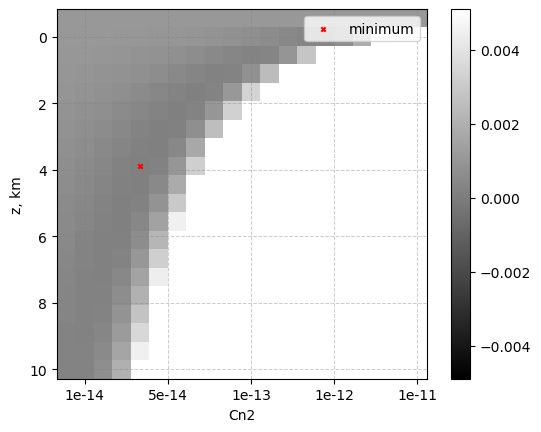

In [21]:
plt.figure()
plt.imshow(R2, vmin=R2[np.unravel_index(np.argmin(R2), R2.shape)]-0.005, 
                       vmax=R2[np.unravel_index(np.argmin(R2), R2.shape)]+0.005, cmap='gray')
plt.colorbar()

plt.scatter(np.unravel_index(np.argmin(R2), R2.shape)[1], np.unravel_index(np.argmin(R2), R2.shape)[0], color='red', s=10, 
            marker='x', label='minimum')

plt.xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-14', '1e-13', '1e-12', '1e-11'])
plt.yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
plt.xlabel('Cn2')
plt.ylabel('z, km')
plt.legend()
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

plt.savefig('D:/astro/R.png', bbox_inches='tight')

Filename: D:/astro/domecam/defocus2000m_5_130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   (659, 493, 200)   float64   



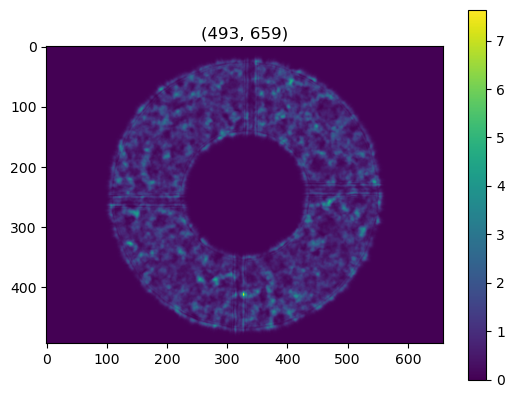

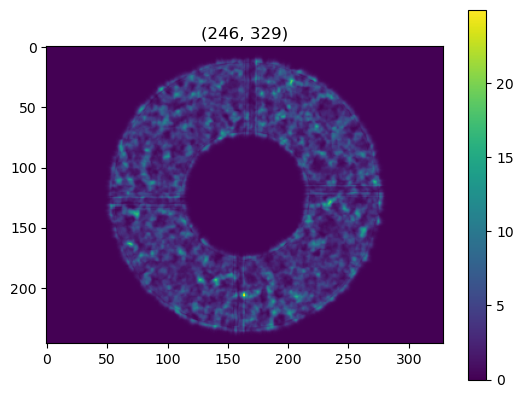

In [83]:
def binning(image, factor=None):
    # https://stackoverflow.com/questions/36063658/how-to-bin-a-2d-array-in-numpy
    # https://scipython.com/blog/binning-a-2d-array-in-numpy/
    
    image = image[:-(image.shape[0] - factor*(image.shape[0]//factor)), :-(image.shape[1] - factor*(image.shape[1]//factor))]
    res = image.reshape(image.shape[0]//factor, factor, image.shape[1]//factor, factor)
    res = res.sum(1).sum(2)
    return res
    
with fits.open("D:/astro/domecam/defocus2000m_5_130.fits") as f:
    f.info()
    tmp_img = (f[0].data)[5]


plt.figure()
plt.imshow(tmp_img)
plt.title(f'{tmp_img.shape}')
plt.colorbar()

tmp_img2 = binning(tmp_img, factor=2)

plt.figure()
plt.imshow(tmp_img2)
plt.title(f'{tmp_img2.shape}')
plt.colorbar()
print()